In [1]:
import sys
import os, sys, tarfile
import numpy as np
import matplotlib.pyplot as plt
import urllib
from PIL import Image
from keras.optimizers import RMSprop, SGD

from keras.models import load_model
import keras.backend as K
import data_preprocessing, data_generator, visual, label_parser, data_postprocessing, evaluator
import pdb
import tensorflow as tf

config = tf.ConfigProto()    #to limit TensorFlow resources
config.gpu_options.allow_growth = True
tf.Session(config = config)

%matplotlib inline

%load_ext autoreload
%autoreload 2

C:\Users\Vital\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TRAIN_PATH = '../udacity_driving_datasets/'
TEST_PATH = '../udacity_driving_datasets/'

In [3]:
train_ann = label_parser.parse_annotation_json(TRAIN_PATH, 'labels_train.json')
test_ann = label_parser.parse_annotation_json(TEST_PATH, 'labels_val.json')
print("len(train_ann) = ",len(train_ann))
print("len(test_ann) = ", len(test_ann))

len(train_ann) =  13038
len(test_ann) =  683


In [4]:
size = 224
config_test  = {'grid_w':7, 'grid_h':7, 'img_w' : size, 'img_h' : size, 'is_augment' : False, 'batch_size' : 100}
GRID_W = config_test['grid_w']
GRID_H = config_test['grid_h']
input_w = config_test['img_w']
input_h = config_test['img_h']
testGenerator = data_generator.BatchGenerator(test_ann, config_test)

iteration_num =  7


In [5]:
import tensorflow as tf
def YOLO_loss(y_true, y_pred):
    mask_obj = K.expand_dims(y_true[..., 0], axis=-1)
    mask_no_obj = 1 - mask_obj
    loss_obj = K.sum(K.square(y_true-y_pred)*mask_obj)                             #Loss_xywhp for object
    loss_no_obj = K.sum(K.square(y_true[...,0]-y_pred[...,0])*mask_no_obj[...,0] ) #only confidence
    N_obj = tf.reduce_sum(tf.to_float(mask_obj > 0.0))
    N_no_obj = tf.reduce_sum(tf.to_float(mask_no_obj > 0.0))
    return loss_obj / (N_obj + 1e-06) + 5 * loss_no_obj / (N_no_obj + 1e-06)       #because only 1 from 5 values (p,x,y,w,h)

In [6]:
from keras.utils.generic_utils import get_custom_objects
from keras.models import load_model
get_custom_objects().update({"YOLO_loss": YOLO_loss})
model = load_model("YOLO_Udacity", custom_objects={ 'loss': YOLO_loss } )

In [7]:
x_batch, y_batch = testGenerator.__getitem__(0)
img_num = 2
y_pred = model.predict(x_batch)
np.set_printoptions(precision=3, suppress = True)

print(y_pred[0,:,:,0])

[[ 0.006  0.021  0.003  0.107  0.003  0.003  0.027]
 [ 0.033 -0.045  0.006  0.059 -0.042  0.039  0.023]
 [ 0.061  0.02  -0.005  0.028 -0.015  0.001  0.057]
 [ 0.265  0.156  0.281  0.554  0.625  0.096  0.207]
 [ 0.296  0.093  0.074  0.144  0.286  0.269  0.042]
 [ 0.008 -0.01  -0.045 -0.016  0.019 -0.003  0.066]
 [ 0.03  -0.046 -0.019  0.018 -0.004 -0.003 -0.005]]


In [8]:
y_batch[0,:,:,0]

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [9]:
decoder = data_postprocessing.Encoder(GRID_W, GRID_H, input_w, input_h, 0.5)

In [10]:
pred_rects_encoded, scores = decoder.encode(y_pred)
GT_rects_encoded  = decoder.encode_GT(y_batch)

In [11]:
#convert pred_rects_encoded, scores to format 'img_id' -> {'boxes':[box], 'rects': [rect]}
#GT_rects_encoded to format 'img_id' -> [box]
#
pred_boxes = {}
gt_boxes = {}
for i in range(len(scores) ):
    pred_boxes[str(i)] = {}
    pred_boxes[str(i)]['boxes'] = pred_rects_encoded[i]
    pred_boxes[str(i)]['scores'] = scores[i]
    gt_boxes[str(i)] = GT_rects_encoded[i]

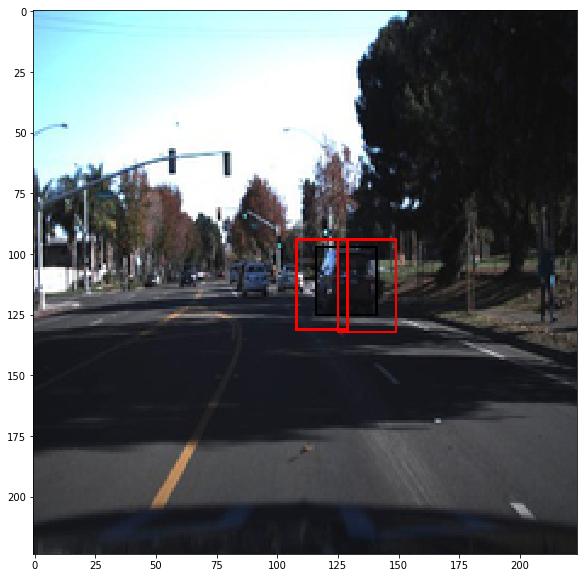

In [12]:
test_image = x_batch[0]*255.0

plt.rcParams['figure.figsize'] = 10, 10


plt.imshow(visual.draw_image_pred_GT(test_image, GT_rects_encoded[0], pred_rects_encoded[0]) )
# plt.imshow(visual.draw_image_pred_GT(test_image, rects_GT) )

In [13]:
res = evaluator.get_avg_precision_at_iou(gt_boxes,pred_boxes, 0.5)

In [14]:
ap = res['avg_prec']
prec = res['precisions']
recall = res['recalls']
print("ap = %.3f"%ap)

ap = 0.300


"YOLO1_scratch_multi_obj" - ap=0.752
"YOLO1_scratch_multi_obj_light" - ap = 0.654
"YOLO_scratch" - ap = 0.763
"YOLO_scratch112" - ap = 0.666

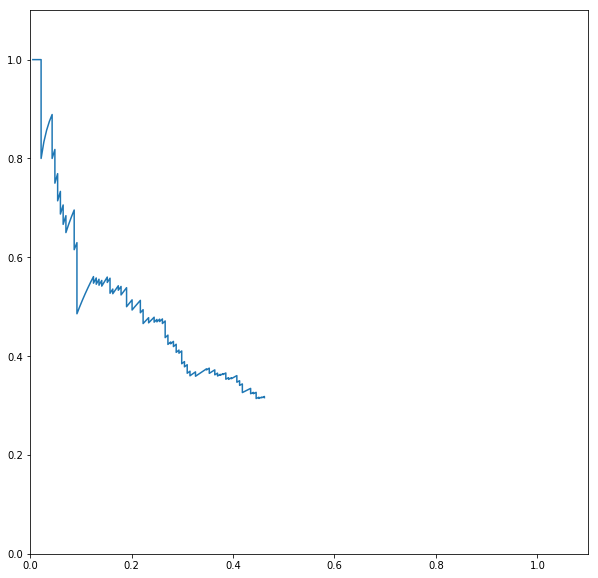

In [29]:
ax = plt.gca()

ax.set_xlim([0.0,1.1])
ax.set_ylim([0.0,1.1])
plt.plot(recall,prec)
plt.figure(figsize=(5,4))


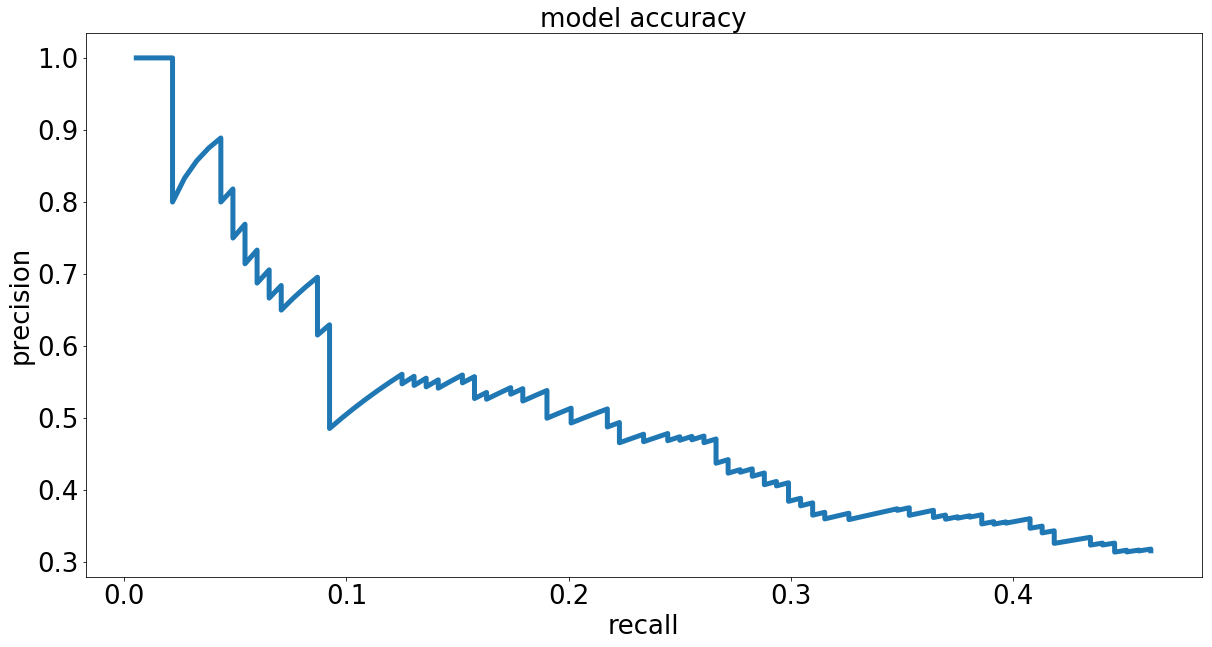

NameError: name 'LeNet' is not defined

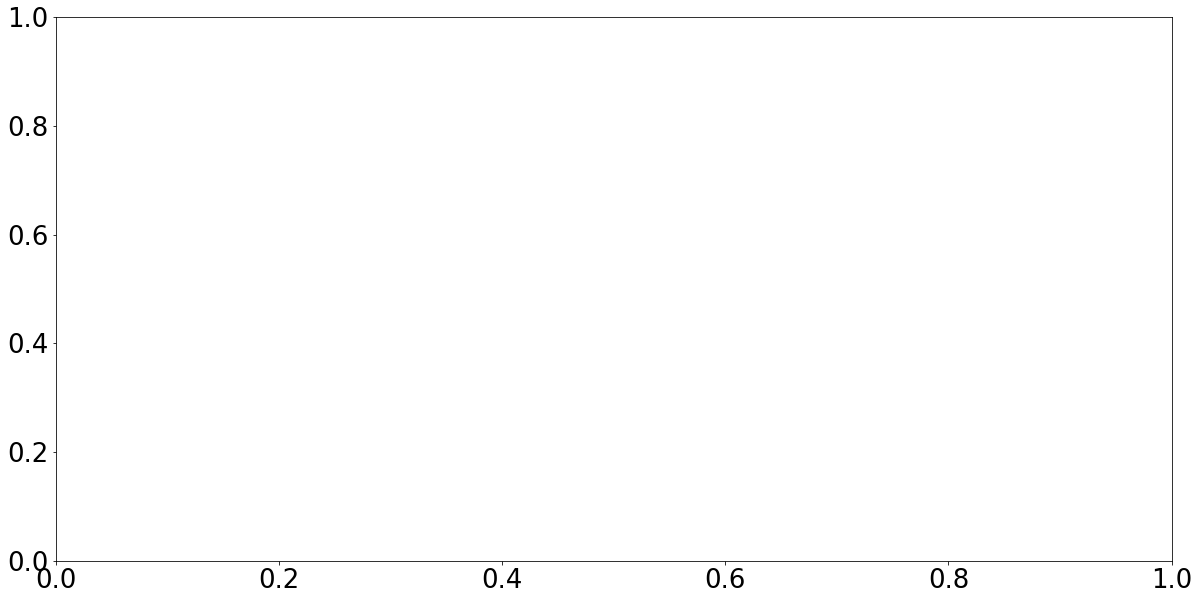

In [30]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['lines.markersize'] = 30
plt.rcParams['lines.linewidth'] = 5

fig, ax = plt.subplots()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
    
# summarize history for accuracy   
plt.plot(recall, prec)
plt.title('model accuracy', fontsize = 26)
plt.ylabel('precision', fontsize = 26)
plt.xlabel('recall', fontsize = 26)
plt.show()

fig, ax = plt.subplots()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
    
# summarize history for loss
plt.plot(LeNet.history.history['loss'])
plt.plot(LeNet.history.history['val_loss'])
plt.title('model loss', fontsize = 26)
plt.ylabel('loss', fontsize = 26)
plt.xlabel('epoch', fontsize = 26)
plt.legend(['train', 'test'], loc='upper left', fontsize = 26)
plt.show()